<a id=top-page></a>

# `pykitPIV` demo: Train a convolutional variational autoencoder

In this Jupyter notebook, we show how the available functionalities from the machine learning module (`pykitPIV.ml`) can be used to train a convolutional variational autoencoder (CVAE). The trained CVAE model generates new velocity fields ($u$ and $v$ components) that belong to the distribution of some experimental data. New PIV snapshots can then be generated
with the newly generated velocity fields. Hence, this approach can be used to extend the training data for transfer learning and can help adapt a machine learning model to the changing experimental conditions.

The illustration below shows the possible loop for training the CVAE:

<div style="text-align:center;">
    <img src="../docs/images/CVAE.svg" style="height:500px">
</div>

This tutorial was built from: https://www.tensorflow.org/tutorials/generative/cvae.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#training-data">Create/load training data</a></li>
        <ul>
        <li><a href="#prepare-data">Prepare training data for TensorFlow</a></li>
        </ul>
    <li><a href="#parameteres-of-CVAE">Parameters of the convolutional variational autoencoder</a></li>
    <li><a href="#train-CVAE">Train the variational autoencoder</a></li>

    

</ol>
<p></p>
</div>
<br>

***

In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from pykitPIV import PIVDatasetPyTorch
from IPython import display
import glob
import imageio
import PIL
import time
from pykitPIV import FlowField, Image, PIVCVAE

2025-05-23 13:35:33.400924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

In [3]:
cmap = cmc.oslo_r

<a id=training-data></a>

***

## Create/load training data

[Go to the top](#top-page)

Below, we create dummy training data (velocity fields), which can be replaced by data coming from an experiment.

In [4]:
n_images = 10000
size = (28, 28)

In [5]:
flowfield = FlowField(n_images=n_images,
                      size=size,
                      size_buffer=0,
                      time_separation=1,
                      dtype=np.float32,
                      random_seed=100)

In [6]:
tic = time.perf_counter()

flowfield.generate_random_velocity_field(displacement=(1, 1),
                                         gaussian_filters=(5, 10),
                                         n_gaussian_filter_iter=3)

toc = time.perf_counter()

print(f'Total time: {(toc - tic)/60:0.1f} minutes.')

Total time: 0.1 minutes.


Inspect the training velocity field components:

In [7]:
image = Image()

In [8]:
image.add_flowfield(flowfield)

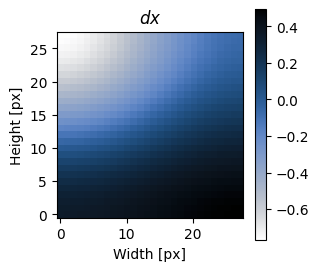

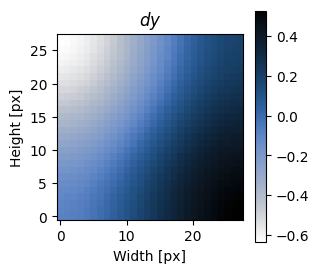

In [9]:
image.plot_field(0,
                 field='velocity',
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 title=('$dx$', '$dy$'),
                 cmap=cmc.oslo_r,
                 cbar=True,
                 origin='lower',
                 figsize=(3,3),
                 filename=None);

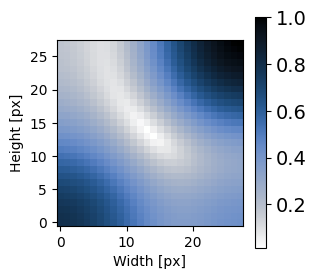

In [10]:
image.plot_field_magnitude(7,
                 field='velocity',
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap=cmc.oslo_r,
                 cbar=True,
                 figsize=(3,3),
                 filename=None);

<a id=prepare-data></a>

### Prepare training data for TensorFlow

[Go to the top](#top-page)

In [11]:
split_at = 9000

Normalize the velocity fields, so that each component in each image has a range between $\langle 0, 1 \rangle$:

In [12]:
vector_field = flowfield.velocity_field

min_vals = vector_field.min(axis=(2, 3), keepdims=True)
vector_field = vector_field - min_vals

max_vals = vector_field.max(axis=(2, 3), keepdims=True)
vector_field = vector_field / (max_vals)

In [13]:
train_images = vector_field[0:split_at,:,:,:]
test_images = vector_field[split_at::,:,:,:]

train_images = np.transpose(train_images, (0, 2, 3, 1))
test_images = np.transpose(test_images, (0, 2, 3, 1))

In [14]:
train_images.shape

(9000, 28, 28, 2)

In [15]:
test_images.shape

(1000, 28, 28, 2)

In [16]:
train_size = train_images.shape[0]
batch_size = 32
test_size = test_images.shape[0]

In [17]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

<a id=parameteres-of-CVAE></a>

***

## Parameters of the convolutional variational autoencoder

[Go to the top](#top-page)

In [18]:
n_channels = 2

In [19]:
input_shape = (size[0], size[1], n_channels)

Specify the learning rate and the optimizer:

In [20]:
learning_rate = 0.0001

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Number of epochs:

In [22]:
epochs = 20

We specify the dimensionality of the latent space, $d$. Note that this dimensionality dictates how many independent marginal Gaussian distributions will be used to represent our input data. For example, for `latent_dim=2`, we will have two Gaussians, and therefore the vector of means will have two elements:

$$
\pmb{\mu} = [\mu_1, \mu_2]
$$

and the vector of log-variances will have two elements:

$$
\pmb{\ln(\sigma^2)} = [\ln(\sigma_1^2), \ln(\sigma_2^2)]
$$

In [23]:
latent_dim = 2

Number of new velocity fields to generate:

In [24]:
n_examples_to_generate = 16

We specify the random number, $\varepsilon$, for generation of new samples:

In [25]:
random_vector_for_generation = tf.random.normal(shape=[n_examples_to_generate, latent_dim])

We define the log- probability density function (log-PDF) for a (potentially multivariate) Gaussian distribution.


Recall that for a single Gaussian PDF, $\mathcal{N}(z \mid \mu, \sigma^2)$, we can compute its logarithm, which gives:

$$
\log \big( \mathcal{N}(z \mid \mu, \sigma^2) \big) = -\frac{1}{2} \left( \frac{(z - \mu)^2}{\sigma^2} + \ln(2\pi) + \ln \sigma^2 \right)
$$

This is precisely the computation done by the function below, but we also sum across all $d$ Gaussian distributions that we are creating in our CVAE (we always have `latent_dim` many of them):

$$
\text{log-PDF} = \sum_{j=1}^{d} \log \big( \mathcal{N}(z \mid \mu_j, \sigma_j^2) \big)
$$

In [26]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    
    log2pi = tf.math.log(2.0 * np.pi)
    
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

Note that this summation does not mean that we are generating a Gaussian mixture! Rather, we are generating a product of individual Gaussian marginals:

$$
p(\mathbf{z}) = \prod_{j=1}^{d} \mathcal{N}(z_j \mid \mu_j, \sigma_j^2)
$$

since the natural logarithm of this gives:

$$
\ln p(\mathbf{z}) = \sum_{j=1}^{d} \ln \mathcal{N}(z_j \mid \mu_j, \sigma_j^2)
$$

We define the complete loss function for the CVAE which, in essence, aims to maximize the evidence lower bound (ELBO).





In [27]:
def compute_loss(model, x):
    
    mean, logvar = model.encode(x)
    
    z = model.reparameterize(mean, logvar)
    
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    
    logpz = log_normal_pdf(z, 0., 0.)
    
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

<a id=train-CVAE></a>

***

## Train the variational autoencoder

[Go to the top](#top-page)

In [28]:
@tf.function
def train_step(model, x, optimizer):
    
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Initialize the convolutional autoencoder as a `pykitPIV.ml.PIVCVAE` object:

In [29]:
model = PIVCVAE(input_shape=input_shape, 
                latent_dimension=latent_dim)

In [36]:
def generate_and_save_images(model, epoch, test_sample):
    
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
      
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap=cmap)
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [31]:
# Pick a sample of the test set for generating output images
assert batch_size >= n_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:n_examples_to_generate, :, :, :]

2025-05-23 13:35:51.072998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 20, Test set ELBO: -972.5469360351562, time elapse for current epoch: 6.816781759262085


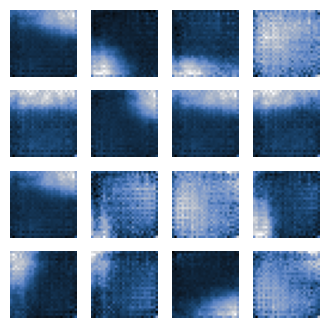

In [32]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    

    start_time = time.time()
    
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
      
    elbo = -loss.result()
    
    display.clear_output(wait=False)
    
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    
    generate_and_save_images(model, epoch, test_sample)

In [33]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

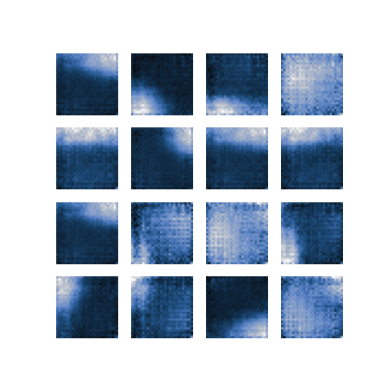

In [34]:
plt.imshow(display_image(epoch))
plt.axis('off')

In [35]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image_for_gif = imageio.imread(filename)
    writer.append_data(image_for_gif)
  image_for_gif = imageio.imread(filename)
  writer.append_data(image_for_gif)

/var/folders/25/33sbb31s5flf87qk45kgwk9r0000gn/T/ipykernel_2460/378861652.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_for_gif = imageio.imread(filename)
/var/folders/25/33sbb31s5flf87qk45kgwk9r0000gn/T/ipykernel_2460/378861652.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_for_gif = imageio.imread(filename)


***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)